### Clustering Algorithms

In [1]:
import pyspark

from pyspark.sql import SQLContext, SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/14 08:35:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [4]:
cluster_df = spark.read.csv("./clustering_dataset-Copy1.csv", header=True)

In [5]:
cluster_df.show()

+----+----+----+
|col1|col2|col3|
+----+----+----+
|   7|   4|   1|
|   7|   7|   9|
|   7|   9|   6|
|   1|   6|   5|
|   6|   7|   7|
|   7|   9|   4|
|   7|  10|   6|
|   7|   8|   2|
|   8|   3|   8|
|   4|  10|   5|
|   7|   4|   5|
|   7|   8|   4|
|   2|   5|   1|
|   2|   6|   2|
|   2|   3|   8|
|   3|   9|   1|
|   4|   2|   9|
|   1|   7|   1|
|   6|   2|   3|
|   4|   1|   9|
+----+----+----+
only showing top 20 rows



In [6]:
cluster_df.printSchema()

root
 |-- col1: string (nullable = true)
 |-- col2: string (nullable = true)
 |-- col3: string (nullable = true)



In [7]:
cluster_df = cluster_df.withColumn("col1",cluster_df.col1.cast('integer'))
cluster_df = cluster_df.withColumn("col2",cluster_df.col2.cast('integer'))
cluster_df = cluster_df.withColumn("col3",cluster_df.col3.cast('integer'))

In [8]:
cluster_df.printSchema()

root
 |-- col1: integer (nullable = true)
 |-- col2: integer (nullable = true)
 |-- col3: integer (nullable = true)



In [9]:
vectorAssembler = VectorAssembler(inputCols=["col1", "col2", "col3"],
                                 outputCol="features")

In [10]:
vcluster_df = vectorAssembler.transform(cluster_df)
vcluster_df.show(5)

+----+----+----+-------------+
|col1|col2|col3|     features|
+----+----+----+-------------+
|   7|   4|   1|[7.0,4.0,1.0]|
|   7|   7|   9|[7.0,7.0,9.0]|
|   7|   9|   6|[7.0,9.0,6.0]|
|   1|   6|   5|[1.0,6.0,5.0]|
|   6|   7|   7|[6.0,7.0,7.0]|
+----+----+----+-------------+
only showing top 5 rows



### Kmeans

In [15]:
kmeans = KMeans().setK(3)
kmeans = kmeans.setSeed(1)

In [16]:
kmodel = kmeans.fit(vcluster_df)

In [17]:
centers = kmodel.clusterCenters()
centers

[array([35.88461538, 31.46153846, 34.42307692]),
 array([80.        , 79.20833333, 78.29166667]),
 array([5.12, 5.84, 4.84])]

### Bisecting-Kmeans

In [18]:
from pyspark.ml.clustering import BisectingKMeans

In [19]:
bkmeans = BisectingKMeans().setK(3)

In [20]:
bkmeans = bkmeans.setSeed(1)

In [22]:
bkmodel = bkmeans.fit(vcluster_df)


In [23]:
bkcenters = bkmodel.clusterCenters()
bkcenters

[array([5.12, 5.84, 4.84]),
 array([35.88461538, 31.46153846, 34.42307692]),
 array([80.        , 79.20833333, 78.29166667])]

### Find optimal number of clusters using silhouette method

Silhouette score is an evaluation metric for the clustering algorithms. It is a measure of similarity between a data point and the other points in a cluster.

The higher the silhouette score, the better is the clustering. Now, in k means clustering algorithm, the number of clusters (k) is the hyper-parameter to be tuned.

In [25]:
vcluster_df.show(5)

+----+----+----+-------------+
|col1|col2|col3|     features|
+----+----+----+-------------+
|   7|   4|   1|[7.0,4.0,1.0]|
|   7|   7|   9|[7.0,7.0,9.0]|
|   7|   9|   6|[7.0,9.0,6.0]|
|   1|   6|   5|[1.0,6.0,5.0]|
|   6|   7|   7|[6.0,7.0,7.0]|
+----+----+----+-------------+
only showing top 5 rows



In [26]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [27]:
silhouette_scores = []
evaluator = ClusteringEvaluator(featuresCol="features",
                               metricName="silhouette",
                               distanceMeasure="squaredEuclidean")

for k in range(2,11):
    KMeans_ = KMeans(featuresCol="features", k=k)
    KMeans_fit = KMeans_.fit(vcluster_df)
    KMeans_transform = KMeans_fit.transform(vcluster_df)
    evaluation_score = evaluator.evaluate(KMeans_transform)
    silhouette_scores.append(evaluation_score)

In [28]:
silhouette_scores

[0.8467387149751704,
 0.8540025504534153,
 0.7451371752485546,
 0.5943825395773655,
 0.6331049464324029,
 0.6004807650485838,
 0.6386709027425483,
 0.6134028069571862,
 0.6674785288937359]

Text(0, 0.5, 'Silhouette Score')

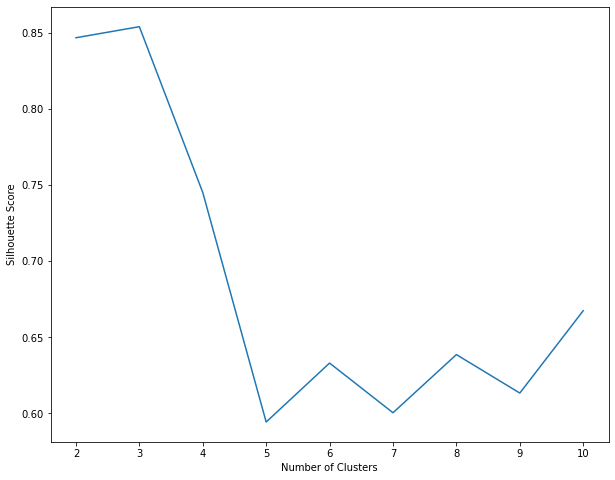

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

As we can see, here k=3 has highest score